## Investigate Problems with Larger Images

Typically when we increase the input size of images, our neural networks perform better.

Here are our current results:

| Size (px) | Epochs | URL | Accuracy | # Runs |
|--|--|--|--|--|
|128|5|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/7d292979ae4bbf8422e710b5aeabc5131d0f83a0/01_InpaintingImageWang/03_ImageWang_Leadboard_128.ipynb)|40.87%| 5 |
|128|20|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/7d292979ae4bbf8422e710b5aeabc5131d0f83a0/01_InpaintingImageWang/03_ImageWang_Leadboard_128.ipynb)|61.15%|3|
|128|80|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/7d292979ae4bbf8422e710b5aeabc5131d0f83a0/01_InpaintingImageWang/03_ImageWang_Leadboard_128.ipynb)|62.18%|1|
|128|200|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/7d292979ae4bbf8422e710b5aeabc5131d0f83a0/01_InpaintingImageWang/03_ImageWang_Leadboard_128.ipynb)|62.03%|1|

| Size (px) | Epochs | URL | Accuracy | # Runs |
|--|--|--|--|--|
|192|5|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/34ab526d39b31f976bc821a4c0924db613c2f7f5/01_InpaintingImageWang/03_ImageWang_Leadboard_192.ipynb)|39.33%|5|
|192|20|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/34ab526d39b31f976bc821a4c0924db613c2f7f5/01_InpaintingImageWang/03_ImageWang_Leadboard_192.ipynb)|64.62%|3|
|192|80|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/34ab526d39b31f976bc821a4c0924db613c2f7f5/01_InpaintingImageWang/03_ImageWang_Leadboard_192.ipynb)|66.76%|1|
|192|200|[Inpainting](https://github.com/JoshVarty/SelfSupervisedLearning/blob/34ab526d39b31f976bc821a4c0924db613c2f7f5/01_InpaintingImageWang/03_ImageWang_Leadboard_192.ipynb)|67.12%|1|

| Size (px) | Epochs | URL | Accuracy | # Runs |
|--|--|--|--|--|
|256|5|[Inpainting]()|19.88%|5|
|256|20|[Inpainting]()|47.26%|3|
|256|80|[Inpainting]()|63.55%|1|
|256|200|[Inpainting]()|67.47%|1|

Notice that accuracy decreases when dealing with `256x256` images and run for 5, 20 and 80 epochs.

### Visualize Activations in PretextTask

In [1]:
import json
import torch

import numpy as np

from functools import partial

from fastai2.callback.hook import HookCallback, ActivationStats

from fastai2.layers import Mish, MaxPool, LabelSmoothingCrossEntropy, flatten_model
from fastai2.learner import Learner
from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter, GrandparentSplitter, CategoryBlock

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from fastai2.vision.all import *

from fastai2.data.transforms import Normalize, parent_label
from fastai2.data.external import download_url, URLs, untar_data


from fastcore.utils import num_cpus

from torch.nn import MSELoss
from torchvision.models import resnet34

In [2]:
# We create this dummy class in order to create a transform that ONLY operates on images of this type
# We will use it to create all input images
class PILImageInput(PILImage): pass

class RandomCutout(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, min_n_holes=5, max_n_holes=10, min_length=5, max_length=50, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length
        

    def encodes(self, x:PILImageInput):
        """
        Note that we're accepting our dummy PILImageInput class
        fastai2 will only pass images of this type to our encoder. 
        This means that our transform will only be applied to input images and won't
        be run against output images.
        """
        
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
        pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        h,w = pixels.shape[:2]

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            pixels[y1:y2, x1:x2, :] = 0
            
        return Image.fromarray(pixels, mode='RGB')

In [3]:
# Default parameters
gpu=None
lr=1e-2
size=256
sqrmom=0.99
mom=0.9
eps=1e-6
epochs=15
bs=64
mixup=0.
opt='ranger',
arch='xresnet50'
sh=0.
sa=0
sym=0
beta=0.
act_fn='Mish'
fp16=0
pool='AvgPool',
dump=0
runs=1
meta=''

In [4]:
# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=0               #NOTE: My GPU cannot run fp16 :'(
arch='xresnet50' 
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
m = xresnet34
act_fn = Mish
pool = MaxPool

In [5]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [6]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    #CHANGE: Input is ImageBlock(cls=PILImageInput)
    #CHANGE: Output is ImageBlock
    #CHANGE: Splitter is RandomSplitter (instead of on /val folder)
    
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5), RandomCutout]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, 
                       get_y=lambda o: o,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [7]:
if gpu is not None: torch.cuda.set_device(gpu)
if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [8]:
size = 160
#CHANGE: I can only fit ~32 images in a batch
bs = 32

dbunch = get_dbunch(size, bs, sh=sh)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']
if not gpu: print(f'lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')

lr: 0.008; size: 160; sqrmom: 0.99; mom: 0.95; eps: 1e-06


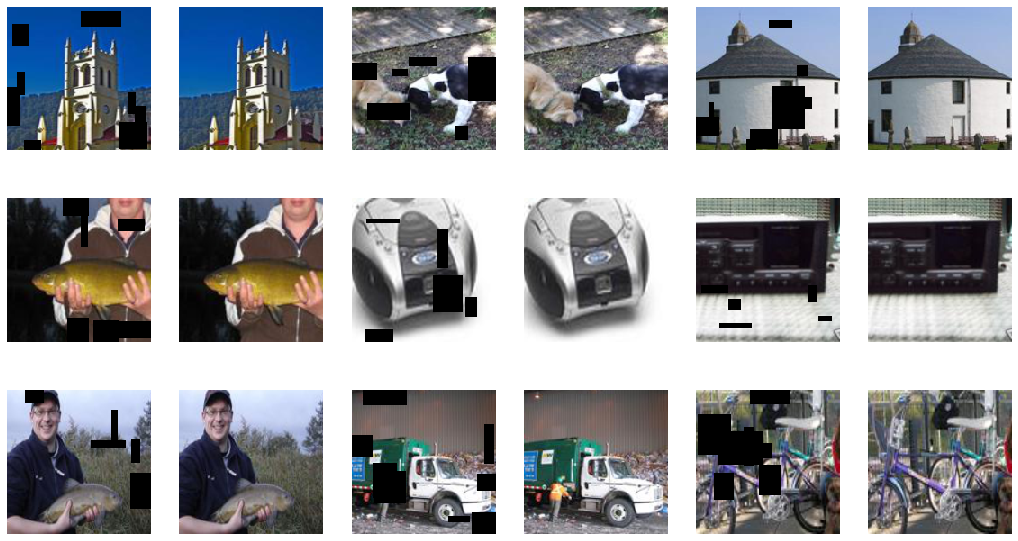

In [9]:
dbunch.show_batch()

In [10]:
#NOTE: We are using MSELoss and vanilla xresnet50
learn = unet_learner(dbunch, m, opt_func=opt_func, metrics=[], loss_func=MSELoss())

# Hook activations
conv1 = learn.model[0][2]
conv2_x = learn.model[0][4]
conv3_x = learn.model[0][5]
conv4_x = learn.model[0][6]
conv5_x = learn.model[0][7]
hook = ActivationStats(every=15, with_hist=True, modules=[conv1, conv2_x, conv3_x, conv4_x, conv5_x])

if dump: print(learn.model); exit()
if fp16: learn = learn.to_fp16()
cbs = [hook]

learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

epoch,train_loss,valid_loss,time
0,0.007556,0.002929,02:41
1,0.004303,0.002808,02:31
2,0.003956,0.002366,02:31
3,0.003534,0.002389,02:34
4,0.003621,0.002319,02:33
5,0.003439,0.002167,02:33
6,0.003328,0.002189,02:34
7,0.003270,0.002113,02:35
8,0.003414,0.002082,02:38
9,0.003297,0.002122,02:36


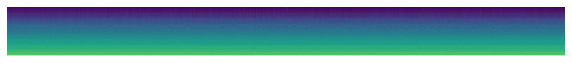

In [11]:
hook.plot_hist(0)

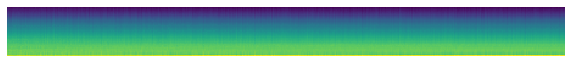

In [12]:
hook.plot_hist(1)

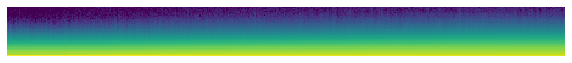

In [13]:
hook.plot_hist(2)

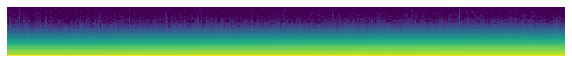

In [14]:
hook.plot_hist(3)

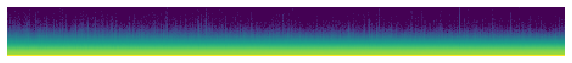

In [15]:
hook.plot_hist(4)

##### 